In [1]:
import numpy as np
from numpy.random import seed
from numpy.random import randint
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import pandas as pd
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
from pprint import pprint
import re
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import nltk
import seaborn as sns
from collections import Counter
nltk.download('stopwords')
from nltk.corpus import stopwords
import funciones as fn
import datetime
import ast

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JOSE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Vamos a realizar una transformación usando Graph Api v4.0
Una base de datos que funciona así: reshape - comments to wide

In [2]:
df = pd.read_excel('voices_of_venezuela_feb_abr_1.xlsx')
for index, row in df.iterrows():
    df.loc[index, 'comments'] = row['comments'][row['comments'].find("["):row['comments'].find("]")+1]
df.comments = df.comments.apply(lambda s: list(ast.literal_eval(s)))
base = pd.DataFrame({"id_post_vv":[], "id":[], "level":[], "message":[], "fecha":[]})
# Para cada fila agarro el post vigente y su id...
id_post_vv = list()
id_post= list()
level= list()
message= list()
fecha= list()
for index, row in df.iterrows():
    id_post_vv.append(index)
    id_post.append(index)
    level.append(1)
    fecha.append(row['created_time'])
    message.append(row['message'].encode('utf8','surrogateescape').decode('utf8','surrogateescape'))
    i = 0
    for item in row['comments']:
        id_post_vv.append(index)
        id_post.append(i)
        i += 1
        level.append(2)
        item = dict(item)
        fecha.append(item.get('created_time'))
        try:
            message.append(item.get('message').encode('utf8','surrogateescape').decode('utf8','surrogateescape'))
        except:
            print(item)
            message.append(item.get('message').encode('utf8','surrogateescape').decode('utf8','surrogateescape'))
base['id_post_vv'] = id_post_vv
base['id'] = id_post
base['fecha'] = fecha
base['fecha'] = base['fecha'].apply(lambda a: pd.to_datetime(a).date()) 
base['level'] = level
base['message'] = message
base.head(5)

C:\Users\JOSE\AppData\Local\Temp/ipykernel_15508/3893792141.py:33: FutureWarning: Inferring datetime64[ns, UTC] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  base['fecha'] = fecha


id_post_vv  id  level                                            message  \
0           0   0      1  🎓¡Graduémonos juntos del Estatuto! 🎓  💰La mate...   
1           0   0      2                                     Gracias a Dios   
2           0   1      2               Buenas tardes en cuáles bancos porfa   
3           0   2      2  La semana pasada me acerque a 3 entidades banc...   
4           0   3      2  Y septiembre invisible y en el olvido, nadie n...   

        fecha  
0  2022-04-29  
1  2022-04-29  
2  2022-04-29  
3  2022-04-29  
4  2022-04-29

In [221]:
base.to_excel('Base_vv_feb_abr.xlsx')

In [3]:
df = pd.read_excel('Base_vv_feb_abr.xlsx')
df

Unnamed: 0  id_post_vv  id  level  \
0              0           0   0      1   
1              1           0   0      2   
2              2           0   1      2   
3              3           0   2      2   
4              4           0   3      2   
...          ...         ...  ..    ...   
1805        1805          81  20      2   
1806        1806          81  21      2   
1807        1807          81  22      2   
1808        1808          81  23      2   
1809        1809          81  24      2   

                                                message      fecha  
0     🎓¡Graduémonos juntos del Estatuto! 🎓  💰La mate... 2022-04-29  
1                                        Gracias a Dios 2022-04-29  
2                  Buenas tardes en cuáles bancos porfa 2022-04-29  
3     La semana pasada me acerque a 3 entidades banc... 2022-04-29  
4     Y septiembre invisible y en el olvido, nadie n... 2022-04-29  
...                                                 ...        ...  
1805  Hola buenas tardes mi esposo tubo su cita biom... 2022-02-01  
1806  Vamos a ver si la pego con que me puedan respo... 2022-02-01  
1807  Y tambien me paso q el el dia 22 de enero sali... 2022-02-01  
1808            Gracias por siempre tenernos informados 2022-02-01  
1809  Si claro mi duda es que ha pasado con los regi... 2022-02-01  

[1810 rows x 6 columns]

In [4]:
#Eliminamos los URL: Todo lo que empieza por  HTTP
df['Clean_Text']=df['message'].replace(r"http\S+", '', regex=True)
#Eliminamos todos los hashtags
df['Clean_Text']=df['Clean_Text'].replace('#\\w+', '', regex=True)
#Eliminamos los signos de puntuación repetidos dentro de los tweets
df['Clean_Text']=df['Clean_Text'].replace(r'([^0-9a-zA-Z])\1+', r'\1', regex=True)
#Eliminamos los signos de puntuación al inicio de un tweet
df['Clean_Text']=df['Clean_Text'].replace(r'^[^0-9a-zA-Z@#]+', '', regex=True)
#Eliminamos los dobles espacios
df['Clean_Text']=df['Clean_Text'].replace(r'()\1+', r'\1\1', regex=True)
#Eliminamos las df repetivas dentro de las palabras
df['Clean_Text']=df['Clean_Text'].replace(r'(.)\1+', r'\1\1', regex=True)
# Quitar las comillas de los textos
df['Clean_Text']=df['Clean_Text'].replace('"', '', regex=True)
# Remover puntuaciones innecesarias
df['Clean_Text'] = df['Clean_Text'].map(lambda x: re.sub('[,\.!?]', '', str(x)))
df['Clean_Text']=df['Clean_Text'].str.replace('RT', '')
# Remover mayúsculas de inicio de texto
df['Clean_Text'] = df['Clean_Text'].map(lambda x: x.lower())
#Autores
df['Clean_Text']=df['Clean_Text'].replace(r'@\w+', '', regex=True)
df['Clean_Text']=df['Clean_Text'].str.replace('rt', '')
#Espacios
df['Clean_Text']=df['Clean_Text'].str.strip()
df['Clean_Text']=df['Clean_Text'].replace('Document_No', '')
# Exclude stopwords 
spanish_stopwords=stopwords.words('spanish')
spanish_stopwords.extend(['ser', 'haber','si'])
#spanish_stopwords.extend(usuarios)
spanish_stopwords.remove('no')
spanish_stopwords.remove('ni')
df['Clean_Text_no_stopwords'] = df['Clean_Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (spanish_stopwords) and len(word)>1]))

In [5]:
df['Clean_Text_no_stopwords']

0       graduémonos juntos estatuto 💰la materia hoy ac...
1                                            gracias dios
2                       buenas tardes cuáles bancos porfa
3       semana pasada acerque entidades bancarias ppt ...
4       septiembre invisible olvido nadie da respuesta...
                              ...                        
1805    hola buenas tardes esposo tubo cita biométrica...
1806    vamos ver pego puedan responder escribi dos ve...
1807    tambien paso dia 22 enero salia impreso lugar ...
1808                  gracias siempre tenernos informados
1809    claro duda pasado registros realizaron septiem...
Name: Clean_Text_no_stopwords, Length: 1810, dtype: object

In [12]:
base_graficas = df.copy()
base_graficas['Menciones'] = 1
base_grafica = base_graficas.groupby('fecha').sum()
base_grafica

Unnamed: 0  id_post_vv   id  level  Menciones
fecha                                                    
2022-02-01       46709        2106  381     51         26
2022-02-02       21162         960  135     23         12
2022-02-03       66717        3016  579     75         38
2022-02-04       30927        1406  228     35         18
2022-02-05       61270        2782  572     71         36
...                ...         ...  ...    ...        ...
2022-04-30          58           0   54      8          4
2022-05-01          74           0   70      8          4
2022-05-02          21           0   20      2          1
2022-05-03          45           0   43      4          2
2022-05-05        1010          42   92      8          4

[93 rows x 5 columns]

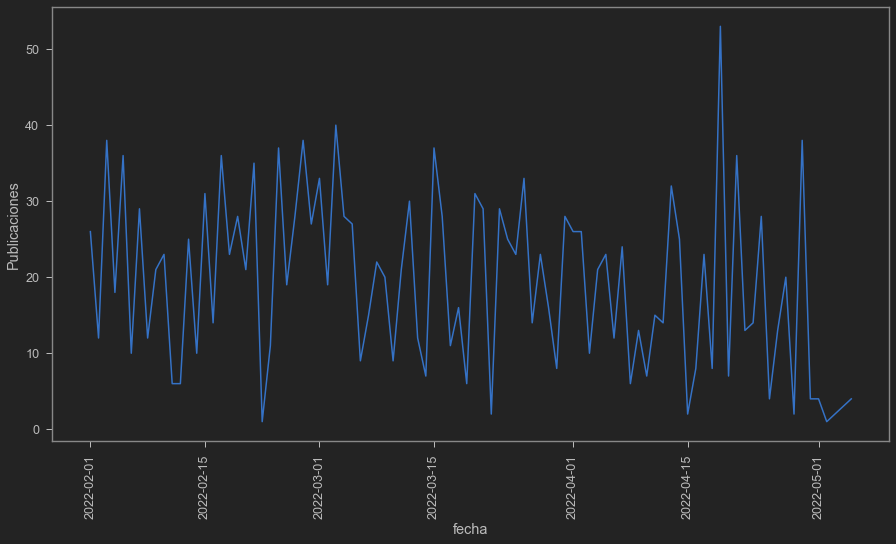

In [15]:
plt.figure(figsize=(15,8))
base_grafica.rename(inplace=True,  columns={"Menciones" : "Publicaciones"})
ax = sns.lineplot(x=base_grafica.index,y=base_grafica["Publicaciones"],data=base_grafica)
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [18]:
base_grafica.sort_values('Publicaciones', inplace=True, ascending=False)
base_grafica.to_excel('Volumenes_totales.xlsx')
base_grafica

Unnamed: 0  id_post_vv   id  level  Publicaciones
fecha                                                        
2022-04-19       11207         454  636    105             53
2022-03-03       45382        2080  616     79             40
2022-02-03       66717        3016  579     75             38
2022-04-29        1053          25  366     75             38
2022-02-27       47018        2146  593     75             38
...                ...         ...  ...    ...            ...
2022-03-22        1651          74   37      4              2
2022-04-28         103           3   25      3              2
2022-05-03          45           0   43      4              2
2022-02-22        1396          63   22      2              1
2022-05-02          21           0   20      2              1

[93 rows x 5 columns]

In [19]:
base_graficas = df.copy()
base_graficas['Menciones'] = 1
base_grafica = base_graficas[base_graficas['level'] == 1].groupby('fecha').sum()
base_grafica

Unnamed: 0  id_post_vv  id  level  Menciones
fecha                                                   
2022-02-01        1784          81  81      1          1
2022-02-02        1758          80  80      1          1
2022-02-03        1732          79  79      1          1
2022-02-04        1706          78  78      1          1
2022-02-05        1680          77  77      1          1
...                ...         ...  ..    ...        ...
2022-04-23         104           4   4      1          1
2022-04-24          78           3   3      1          1
2022-04-26          52           2   2      1          1
2022-04-28          26           1   1      1          1
2022-04-29           0           0   0      1          1

[79 rows x 5 columns]

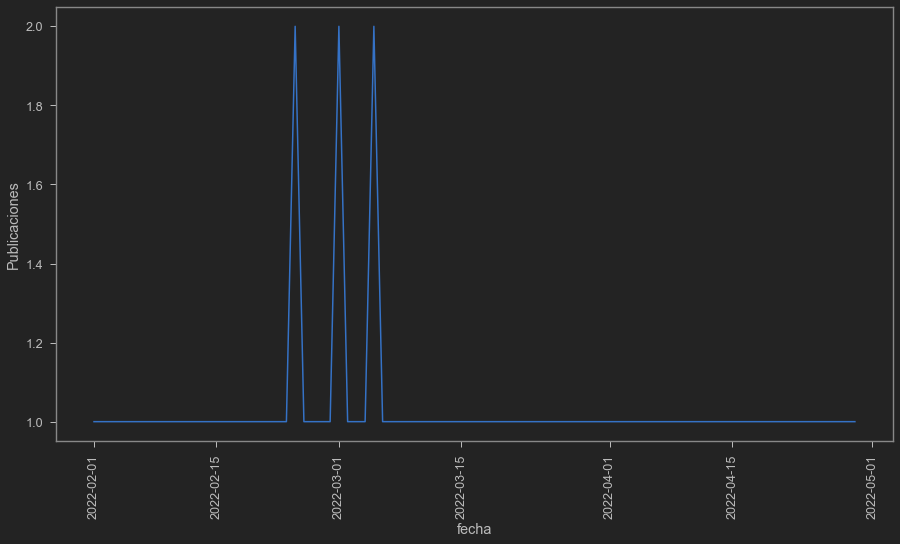

In [20]:
plt.figure(figsize=(15,8))
base_grafica.rename(inplace=True,  columns={"Menciones" : "Publicaciones"})
ax = sns.lineplot(x=base_grafica.index,y=base_grafica["Publicaciones"],data=base_grafica)
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

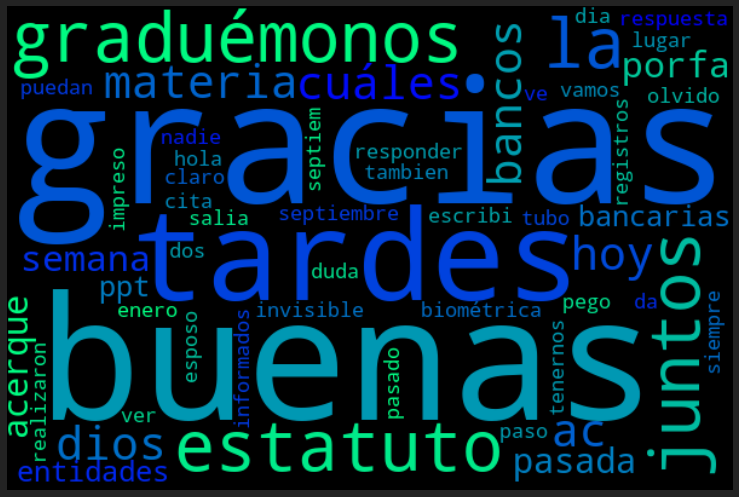

In [247]:
# Word cloud general de todos los posts
series_a_str = str(df["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

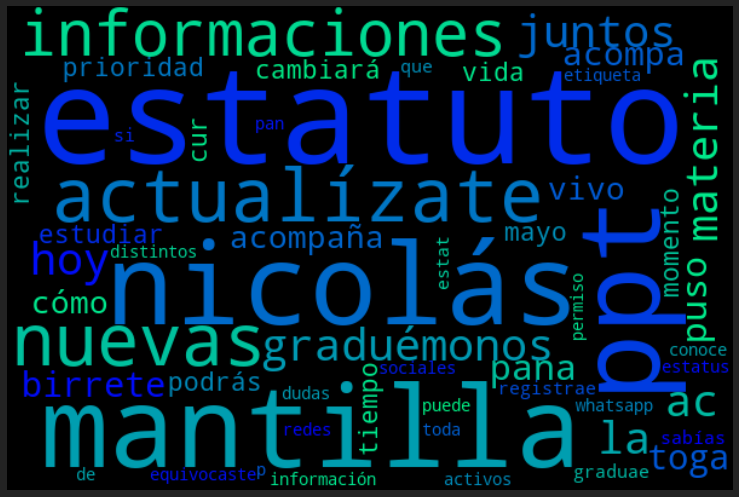

In [248]:
# Word cloud general de los posts de voices of venezuela
df_vv = df[df['level'] == 1]
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

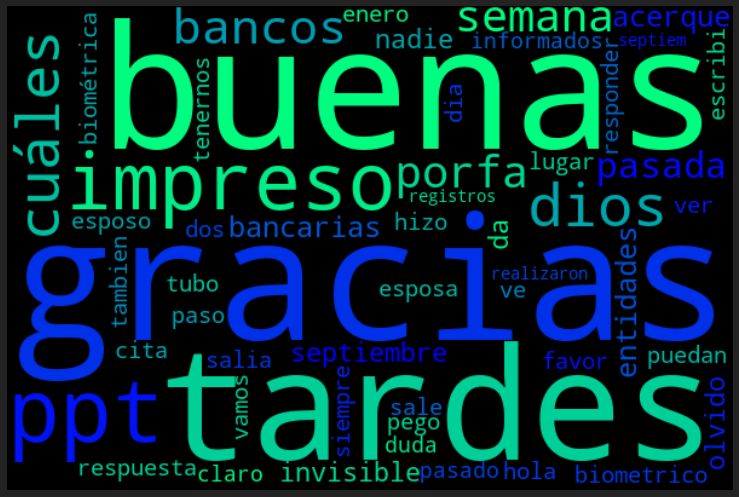

In [249]:
# Word cloud general de los comments hacia voices of venezuela
df_vv = df[df['level'] == 2]
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [21]:
df['fecha_publicacion'] = df['fecha'].dt.strftime('%d/%m/%Y')
df['fecha_publicacion']

0       29/04/2022
1       29/04/2022
2       29/04/2022
3       29/04/2022
4       29/04/2022
           ...    
1805    01/02/2022
1806    01/02/2022
1807    01/02/2022
1808    01/02/2022
1809    01/02/2022
Name: fecha_publicacion, Length: 1810, dtype: object

In [33]:
#from datetime import date, timedelta

#def daterange(start_date, end_date):
#    for n in range(int((end_date - start_date).days)):
#        yield start_date + timedelta(n)

#start_date = date(2022, 1, 1)
#end_date = date(2022, 3, 1) # Y M D
#for single_date in daterange(start_date, end_date):
#    print(single_date.strftime('%d/%m/%Y'))
    

In [22]:

df['mes'] = df['fecha'].dt.month
df['dia'] = df['fecha'].dt.day
df_quincena_1 = df[(df['dia'] <= 15) & (df['mes'] == 2)]
df_quincena_2 = df[(df['dia'] > 15) & (df['mes'] == 2)]
df_quincena_3 = df[(df['dia'] <= 15) & (df['mes'] == 3)]
df_quincena_4 = df[(df['dia'] > 15) & (df['mes'] == 3)]
df_quincena_5 = df[(df['dia'] <= 15) & (df['mes'] == 4)]
df_quincena_6 = df[(df['dia'] > 15) & (df['mes'] == 4)]
df_pico_1 = df[(df['dia'] == 19) & (df['mes'] == 4)]
df_pico_2 = df[(df['dia'] == 3) & (df['mes'] == 3)]
df_pico_3 = df[(df['dia'] == 2) & (df['mes'] == 2)]

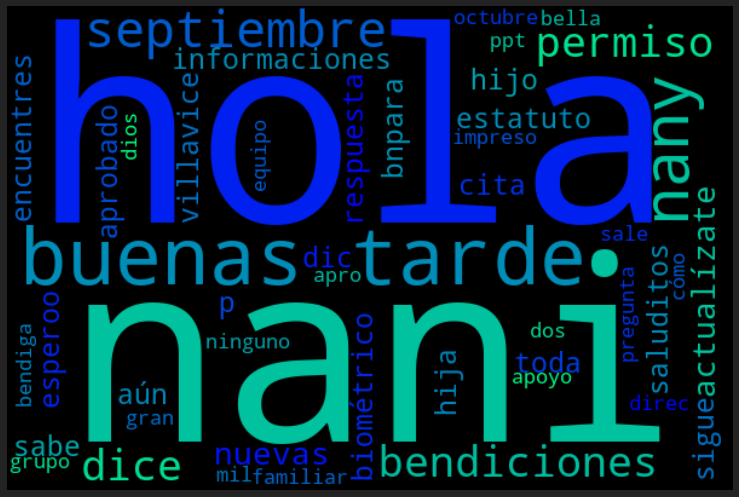

In [25]:
df_vv = df_pico_3
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

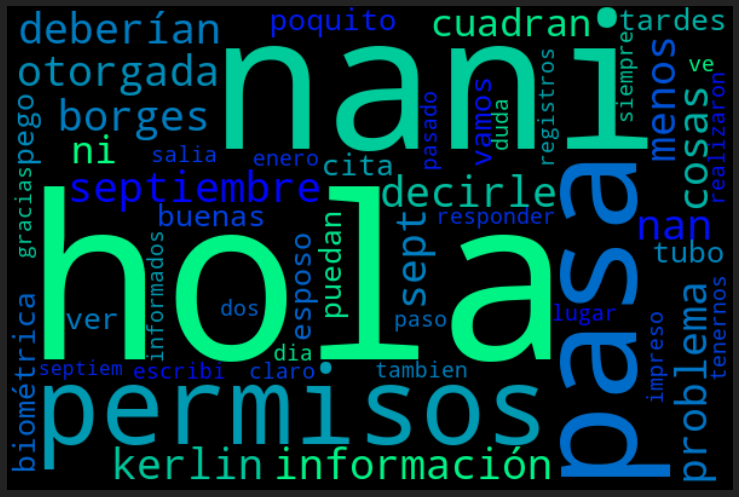

In [252]:
# Word cloud general de la primera quincena
df_vv = df_quincena_1
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

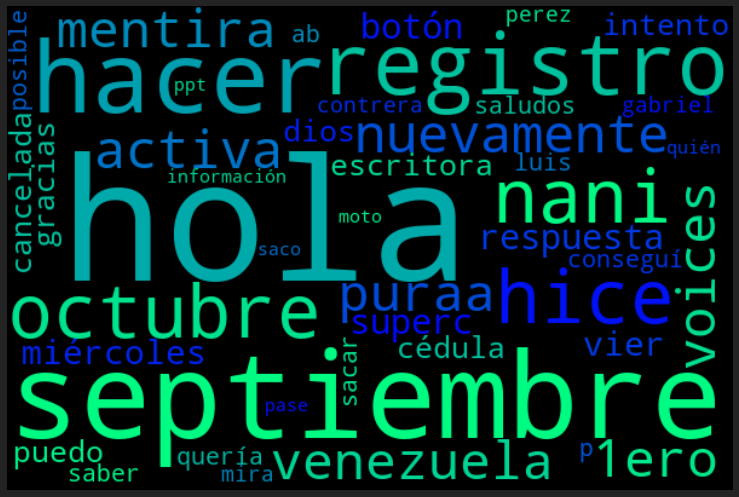

In [253]:
# Word cloud general de la segunda quincena
df_vv = df_quincena_2
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

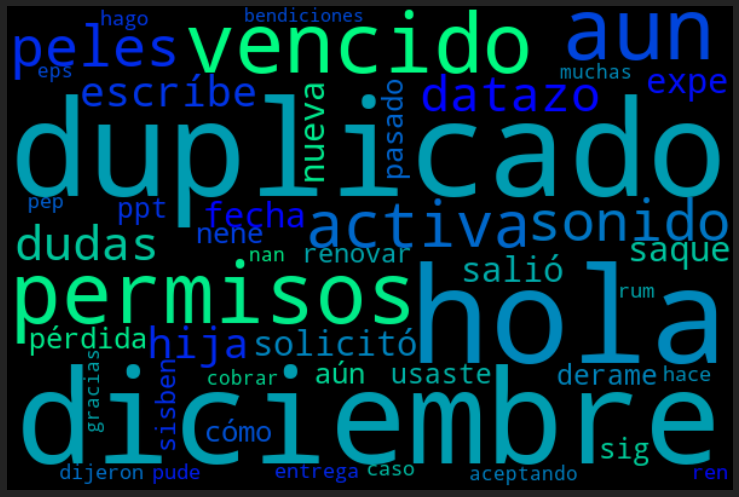

In [254]:
# Word cloud general de la tercera quincena
df_vv = df_quincena_3
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

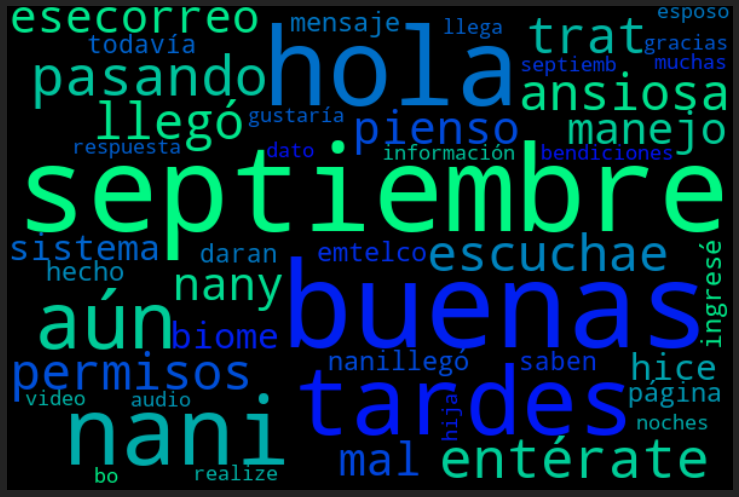

In [255]:
# Word cloud general de la cuarta quincena
df_vv = df_quincena_4
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

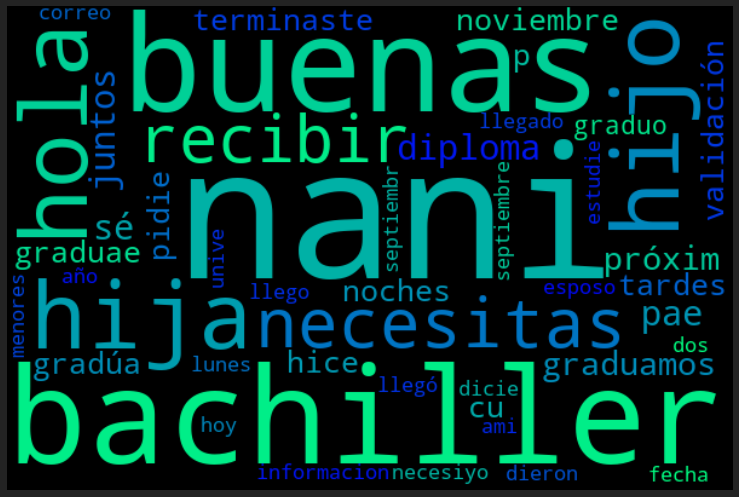

In [258]:
# Word cloud general de la quinta quincena
df_vv = df_quincena_5
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

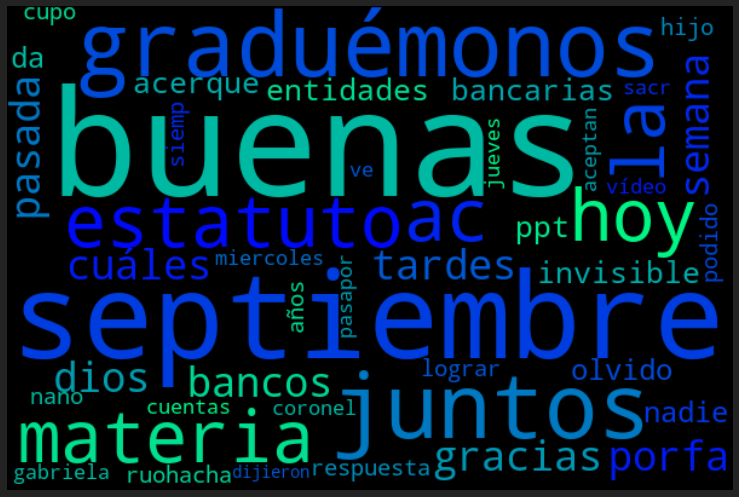

In [257]:
# Word cloud general de la sexta quincena
df_vv = df_quincena_6
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')